<a href="https://colab.research.google.com/github/Sujal9079/Lithium-Ion-Batteries/blob/main/Lithium_ion_batteries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# om sai ram

# Problem 1

### Importing the Libraries needed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### Importing the csv file

In [ ]:
data1 = pd.read_csv('/content/Problem1_data.csv')

### Dropping the unkown column

In [ ]:
data1.drop(columns = ['Unnamed: 0'],axis =1,inplace = True)

### Here we can see, the information regarding the dataset,
1. there are no null values

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81140 entries, 0 to 81139
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  81140 non-null  object 
 1   soc        81140 non-null  int64  
 2   voltage    81140 non-null  float64
 3   current    81140 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ MB


here, we can see rolling statistics of each variable

In [ ]:
data1.describe()

,soc,voltage,current
count,81140.000000,81140.000000,81140.000000
mean,67.109786,53.853164,1.347645
std,24.872373,3.215827,4.148811
min,0.000000,0.000000,0.000000
25%,45.000000,50.900000,0.000000
50%,68.000000,53.300000,0.000000
75%,94.000000,57.500000,0.000000
max,100.000000,58.600000,67.100000


# Task 1 - Data Preprocessing

### Data preprocessing Steps
1. Converting the timestamp to datetime format
2. I have defined the outlier removal code, but it is not necessary to remove the outliers, because it can lead discontinuos data
3. We have created boxplots, to see the distribution of data

In [ ]:
def preprocess_and_visualize(data):
    def timestamp_to_datetime(data):
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        return data.sort_values(by='timestamp').reset_index(drop=True)

 # Here we should not remove the outliers, because, even 1 data point is missing, we get errors in the calculation of FEC

    def interpolate(data):
        return data.interpolate(method='linear')

    def remove_outliers(data, column):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    def create_box_plots(data,value):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(value)

        data.boxplot(column=['soc'], ax=axes[0])
        axes[0].set_title('State of Charge (SOC)')
        axes[0].set_ylabel('SOC (%)')

        data.boxplot(column=['voltage'], ax=axes[1])
        axes[1].set_title('Voltage')
        axes[1].set_ylabel('Voltage (V)')

        data.boxplot(column=['current'], ax=axes[2])
        axes[2].set_title('Current')
        axes[2].set_ylabel('Current (A)')

        plt.tight_layout()
        plt.show()

    # Apply preprocessing steps
    data = timestamp_to_datetime(data)
    # data = remove_duplicates(data)
    data = interpolate(data)

    # for col in ['soc', 'voltage']:
        # data = remove_outliers(data, col) # We wont remove the outliers too

    # Create box plots
    create_box_plots(data,value = 'Box Plots of Battery Data after removing the outliers')

    return data

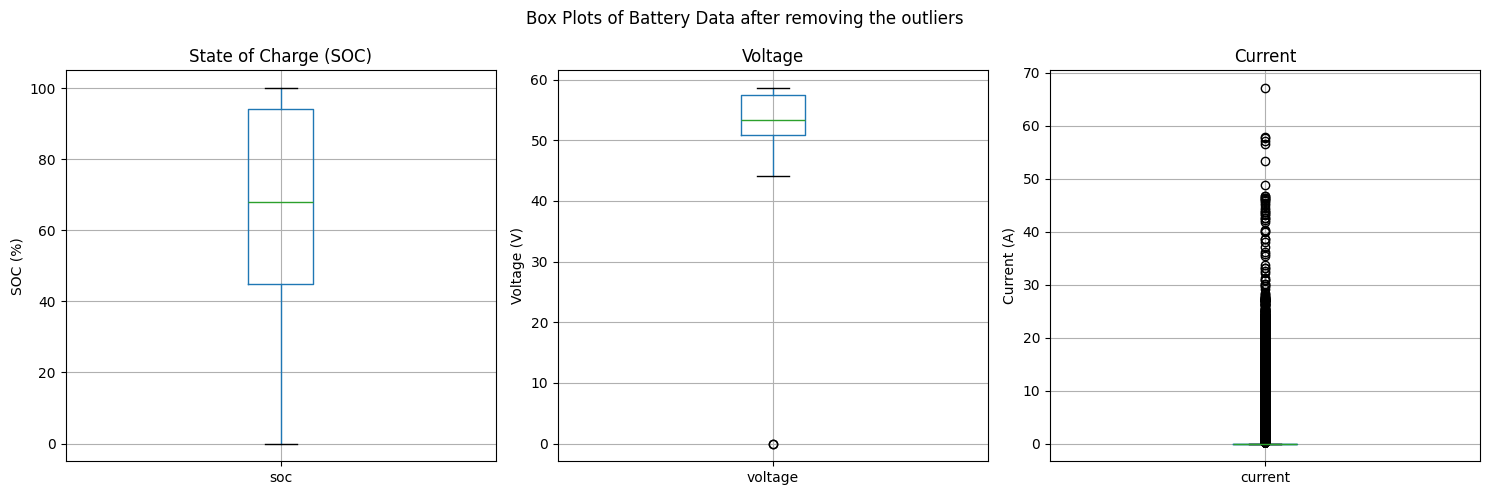

In [ ]:
data1_new = preprocess_and_visualize(data1)

## Important

In the case of the current, maximum around 324560 data points has current value 0A, that means if we apply IQ method for current columns, all the non-zero values will get removed.

So, we are not removing any data here


# Task 2 - Exploratory Data Analysis

### EDA observations
#### 1. Histograms
1. If we see SOC distribution, it is right skewed, has 2 peaks and  maximum no.of users are using the battery at 100% SOC

2. If we see Voltage distribution, it is right skewed, has 2 peaks and and maximum no.of users are using the battery at 58 Volts

3. In the current distribution, it is left skewed, has only 1 peaks and maximum no.of points are at 0 Ampere

#### 2. Line-Plots
1. Here, we can see that, there are two points which are form 1970 year, and remaining all are form, 2021 november to januvary 2022. so these 2 points of the 1970, make line plots as shown below

#### 3. Heat Map
1. from the co-rellation matrix, we can see that, the soc and the voltage are highly proportional to each other.
2. current is independent of voltage and soc values

#### 4. Pairplots

1. We can see clearly that, soc and voltage are directly proportional to each other.

In [ ]:
def plot_histogram(data) :
  fig, axes = plt.subplots(1, 3, figsize=(10, 10))
  fig.suptitle('Distribution of Battery Features')
  sns.histplot(data=data, x='soc', ax=axes[0], kde=True)
  axes[0].set_title('SOC Distribution')
  sns.histplot(data=data, x='voltage', ax=axes[1], kde=True)
  axes[1].set_title('Voltage Distribution')
  sns.histplot(data=data, x='current', ax=axes[2], kde=True)
  axes[2].set_title('Current Distribution')


  plt.tight_layout()  # To adjust subplots
  plt.show()

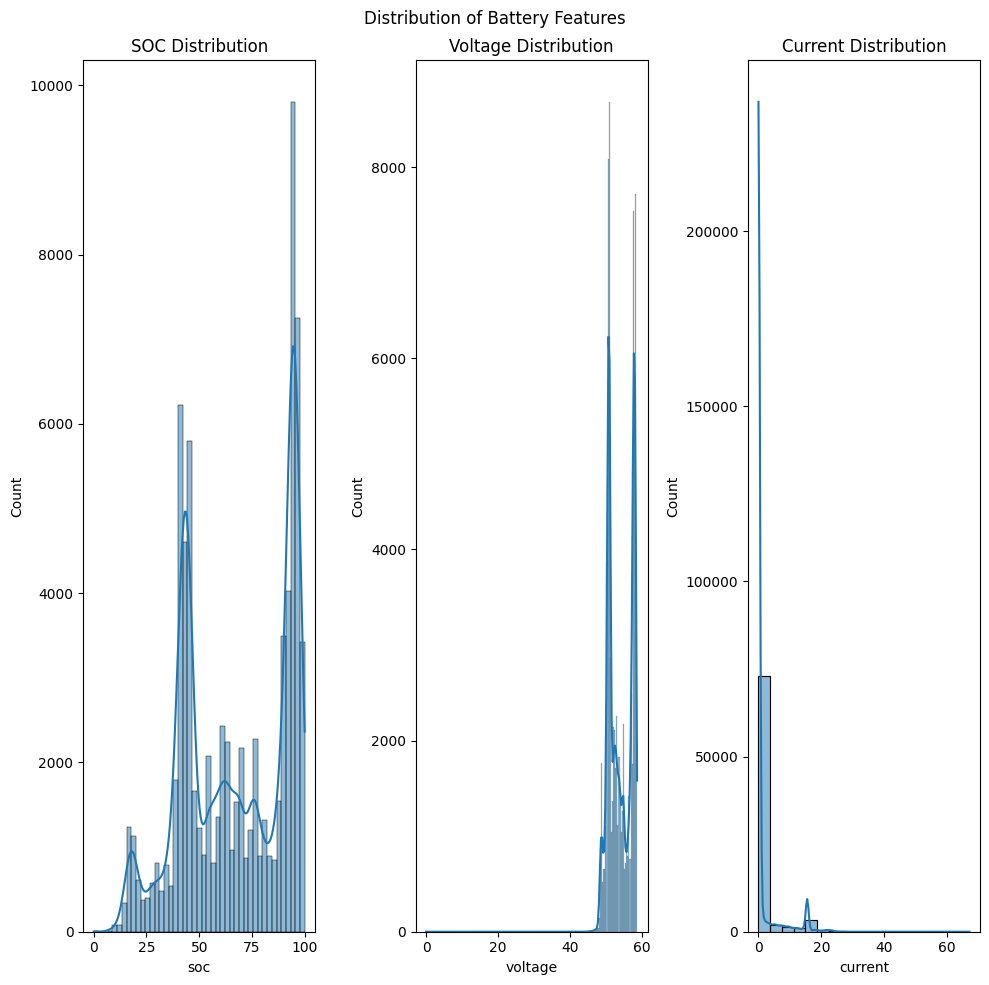

In [ ]:
plot_histogram(data1_new)

In [ ]:
data1.size

324560

## Important

With the help of the line plots, we can have the calculations of the FEC

In [ ]:
# Line-plots
def plot_line(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data['timestamp'], data['soc'], label='SOC')
    plt.plot(data['timestamp'], data['voltage'], label='Voltage')
    plt.plot(data['timestamp'], data['current'], label='Current')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Time Series Plot of SOC, Voltage, and Current')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate timestamps for better visibility
    plt.tight_layout()
    plt.show()

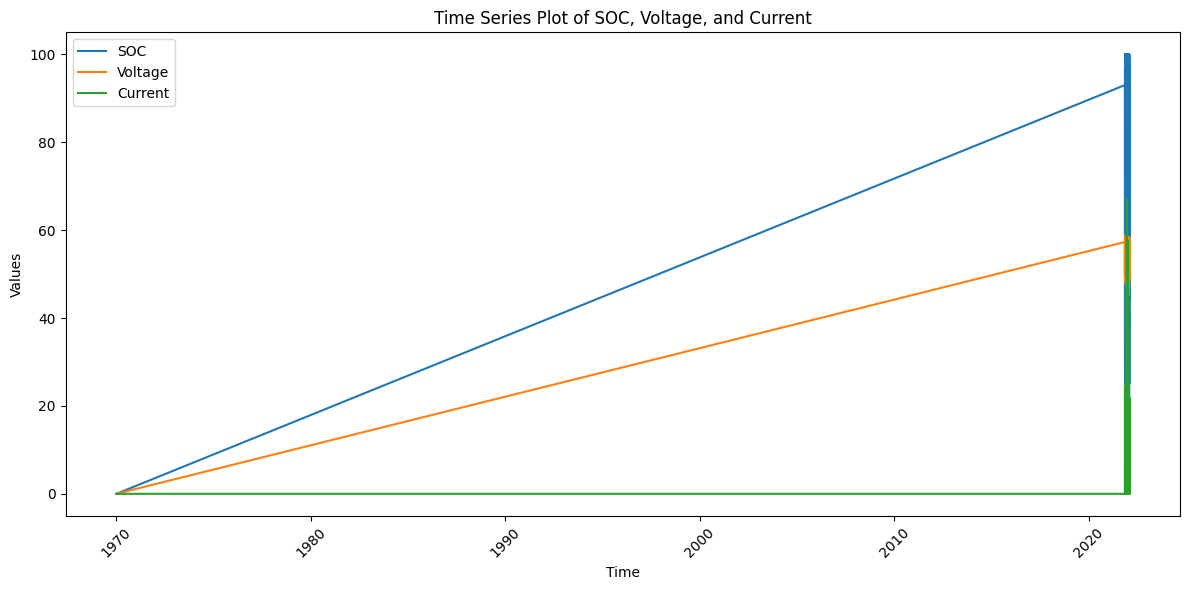

In [ ]:
plot_line(data1_new)

In [ ]:
def plot_correlation(data):
    corr = data[['soc', 'voltage', 'current']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

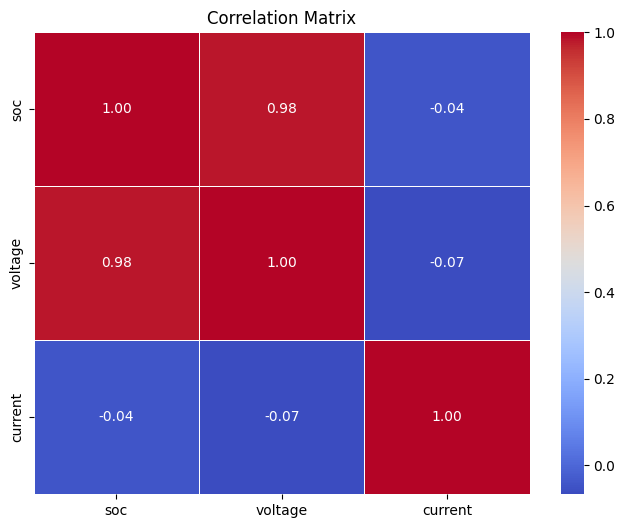

In [ ]:
plot_correlation(data1_new)

In [ ]:
def plot_pairplot(data):
    sns.pairplot(data[['soc', 'voltage', 'current']], kind='scatter', diag_kind='kde')
    plt.suptitle('Pairwise Relationships of Battery Features', y=1.02)
    plt.show()

from these pairplots, we can clearly state that, soc and voltage are highly co-relate to each other

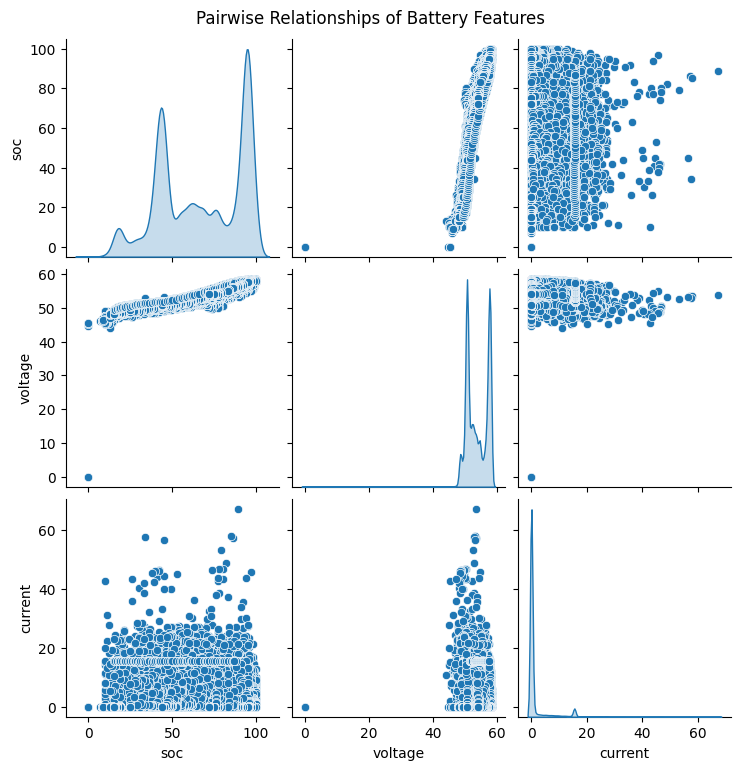

In [ ]:
plot_pairplot(data1_new)

In [ ]:
new_df = data1_new.iloc[2:,:]
new_df.head(20)

,timestamp,soc,voltage,current
2,2021-11-09 07:05:22,93,57.3,0.0
3,2021-11-09 07:05:22,59,52.3,0.0
4,2021-11-09 07:07:33,93,57.1,2.9
5,2021-11-09 07:07:33,93,57.1,0.0
6,2021-11-09 07:07:33,93,56.7,12.8
7,2021-11-09 07:09:44,93,57.1,0.0
8,2021-11-09 07:09:44,93,57.1,0.0
9,2021-11-09 07:11:55,93,57.2,0.0
10,2021-11-09 07:11:55,93,57.2,0.0
11,2021-11-09 07:14:06,93,57.2,0.0


# Task3

### Summary

This code defines a function `calculate_fec(data)`, which calculates the Full Equivalent Cycles (FEC) of a battery based on changes in the state of charge (SOC). It initializes `charging` and `dis_charging` to track charge and discharge levels and iterates through the dataset. If the SOC increases, it marks that index in `new_df['charge current']` as `1` (charging), and if it decreases, it marks it as `-1` (discharging). When both `charging` and `dis_charging` reach 100%, a full cycle is counted, and the values are reduced by 100 to continue tracking. The function returns the total number of full equivalent cycles.

In [ ]:
new_df['charge current'] = 0
def calculate_fec(data) :
  charging = 0
  dis_charging =0
  fec_count =0
  for i in range(1, len(new_df)) :
    current = data['soc'].iloc[i] - data['soc'].iloc[i - 1]

    if (current > 0):
      new_df['charge current'][i] = 1
      charging += current
    elif (current < 0):
      new_df['charge current'][i] = -1
      dis_charging -= current

    if (charging >= 100 and dis_charging >= 100) :
      fec_count+=1
      charging-=100
      dis_charging-=100
  return fec_count

In [ ]:
calculate_fec(new_df)

51

# Task 4 - Calculate the capacity of the battery over first 10 cycles

## Summary
In this,I've calculated battery capacity over charge cycles using a dataset containing timestamps, current, and state of charge (SOC). It first computes the time difference in hours between consecutive timestamps. The function `calculate_capacity(data)` then iterates through the dataset, tracking the accumulated charge (`capacity`) and SOC (`current_soc`). If SOC exceeds 100%, the function adjusts for the excess and starts a new cycle, storing the completed cycle's capacity in `capacity_list`. The process continues until 10 cycles are recorded. The function ensures accurate capacity estimation by considering previous capacity and SOC changes.

In [ ]:
# Calculate time difference in hours
new_df['time_diff_hours'] = new_df['timestamp'].diff().dt.total_seconds()/3600
new_df['time_diff_hours'] = new_df['time_diff_hours'].fillna(0)

In [ ]:
capacity_list = []
def calculate_capacity(data) :
  capacity = 0
  cycle_count = 0
  current_soc = 0
  prev_capacity = 0
  prev_soc = 0
  for i in range(1,len(new_df)) :
    if (cycle_count == 10):
      break
    if (new_df['charge current'].iloc[i] == 1) :
      if (current_soc >= 100):
        remaining_soc = current_soc - 100
        extra_capacity = (prev_capacity*remaining_soc)/prev_soc
        capacity -= extra_capacity
        capacity_list.append(capacity)
        capacity = extra_capacity
        current_soc = remaining_soc
        cycle_count +=1
      capacity += data['current'].iloc[i] * data['time_diff_hours'].iloc[i]
      # print(capacity, data['current'].iloc[i], data['time_diff_hours'].iloc[i])
      current_soc+= data['soc'].iloc[i] - data['soc'].iloc[i-1]
      prev_capacity = data['current'].iloc[i] * data['time_diff_hours'].iloc[i]
      prev_soc = data['soc'].iloc[i] - data['soc'].iloc[i-1]

In [ ]:
capacity_list

[44.88911111111111,
 34.21571882086168,
 33.79531821617536,
 57.57246296296298,
 51.74602777777778,
 42.84488888888889,
 56.921916666666675,
 49.216416666666674,
 48.878583333333346,
 44.71877777777776]

In [ ]:
np.mean(capacity_list)

46.47992222222222

# Problem - 2

In [ ]:
a = pd.read_json('/content/A.json')
b = pd.read_json('/content/B.json')
c = pd.read_json('/content/C.json')

In [ ]:
a= a.transpose()
b = b.transpose()
c = c.transpose()

In [ ]:
a['target'] = 'A'
b['target'] = 'B'
c['target'] = 'C'

In [ ]:
# Re-sampling
df_a = a.sample(n=2084, random_state=0)
df_b = b.sample(n=2084, random_state=0)
df_c = c.sample(n=2084, random_state=0)

In [ ]:
new_data = pd.concat([df_a,df_b,df_c])

In [ ]:
new_data['target'].value_counts()

,count
target,
A,2084
B,2084
C,2084


In [ ]:
# Initialize the necessary columns
new_data['time_differences'] = [[] for _ in range(len(new_data))]
new_data['average currents'] = [[] for _ in range(len(new_data))]
new_data['storage capacity'] = 0
new_data['mean current'] = 0
def calculate_storage(data):
    # Loop through the data
    for i in range(0, len(data)):
        # Calculate time differences
        time_diff = []
        for j in range(0, len(data['d_time'].iloc[i]) - 1):
            one = pd.to_datetime(data['d_time'].iloc[i][j])
            two = pd.to_datetime(data['d_time'].iloc[i][j + 1])
            difference = (two - one).total_seconds() / 3600  # Time difference in hours
            time_diff.append(difference)
        data['time_differences'].iloc[i] = time_diff

        # Calculate average currents
        avg_curr = []
        for j in range(0, len(data['d_current'].iloc[i]) - 1):
            mean = sum(data['d_current'].iloc[i]) / len(data['d_current'].iloc[i])
            data['mean current'].iloc[i] = mean
            one = data['d_current'].iloc[i][j]
            two = data['d_current'].iloc[i][j + 1]
            average = (one + two) / 2
            avg_curr.append(average)
        data['average currents'].iloc[i] = avg_curr

        # Calculate storage capacity
        storage = 0
        for j in range(0, len(data['average currents'].iloc[i])):
            storage -= data['average currents'].iloc[i][j] * data['time_differences'].iloc[i][j]
        data['storage capacity'].iloc[i] = storage

    return data

In [ ]:
calculate_storage(new_data)

,d_voltage,d_time,d_current,target,time_differences,average currents,storage capacity,mean current
18814,"[4179, 4093, 4070, 4052, 4041, 4032, 4026, 402...","[15-07-2024 12:15:15, 15-07-2024 12:15:46, 15-...","[-2500, -2461, -2461, -2460, -2460, -2461, -24...",A,"[0.008611111111111111, 0.012777777777777779, 0...","[-2480.5, -2461.0, -2460.5, -2460.0, -2460.5, ...",4453.468889,-2460.734513
2162,"[4169, 4064, 4042, 4026, 4014, 4004, 3998, 399...","[11-07-2024 00:19:34, 11-07-2024 00:20:05, 11-...","[-2500, -2503, -2503, -2503, -2503, -2503, -25...",A,"[0.008611111111111111, 0.011666666666666667, 0...","[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4551.944444,-2502.973451
5454,"[4164, 4076, 4055, 4043, 4033, 4026, 4021, 401...","[11-07-2024 12:16:19, 11-07-2024 12:16:45, 11-...","[-2500, -2460, -2460, -2460, -2460, -2461, -24...",A,"[0.007222222222222222, 0.014722222222222222, 0...","[-2480.0, -2460.0, -2460.0, -2460.0, -2460.5, ...",4146.091806,-2460.467290
19698,"[4167, 4091, 4070, 4055, 4045, 4038, 4032, 402...","[15-07-2024 17:49:00, 15-07-2024 17:49:28, 15-...","[-2500, -2503, -2503, -2503, -2503, -2503, -25...",A,"[0.0077777777777777776, 0.014722222222222222, ...","[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4775.188333,-2502.606838
20823,"[0, 0]","[15-07-2024 19:54:53, 15-07-2024 19:54:59]","[-2500, 0]",A,[0.0016666666666666668],[-1250.0],2.083333,-1250.000000
...,...,...,...,...,...,...,...,...
8784,"[4182, 4104, 4083, 4067, 4054, 4044, 4037, 403...","[22-05-2024 18:02:52, 22-05-2024 18:03:18, 22-...","[-2500, -2500, -2501, -2501, -2500, -2500, -25...",C,"[0.007222222222222222, 0.012777777777777779, 0...","[-2500.0, -2500.5, -2501.0, -2500.5, -2500.0, ...",4597.844861,-2500.356522
5834,"[4132, 4065, 4048, 4038, 4032, 4027, 4021, 401...","[22-05-2024 04:50:01, 22-05-2024 04:50:29, 22-...","[-2500, -2500, -2501, -2499, -2500, -2501, -25...",C,"[0.0077777777777777776, 0.018333333333333333, ...","[-2500.0, -2500.5, -2500.0, -2499.5, -2500.5, ...",4562.283194,-2500.270270
15068,"[4177, 4101, 4078, 4063, 4050, 4041, 4033, 402...","[23-05-2024 13:03:49, 23-05-2024 13:04:18, 23-...","[-2500, -2499, -2500, -2499, -2499, -2500, -24...",C,"[0.008055555555555555, 0.015, 0.01833333333333...","[-2499.5, -2499.5, -2499.5, -2499.0, -2499.5, ...",4752.982083,-2499.347458
644,"[4165, 4074, 4052, 4039, 4030, 4022, 4015, 401...","[21-05-2024 16:28:55, 21-05-2024 16:29:22, 21-...","[-2550, -2515, -2515, -2514, -2515, -2515, -25...",C,"[0.0075, 0.016666666666666666, 0.0183333333333...","[-2532.5, -2515.0, -2514.5, -2514.5, -2515.0, ...",4667.455556,-2515.254386


In [ ]:
p_data = new_data

In [ ]:
new_data.dropna(inplace = True)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6252 entries, 18814 to 20203
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   d_voltage         6252 non-null   object 
 1   d_time            6252 non-null   object 
 2   d_current         6252 non-null   object 
 3   target            6252 non-null   object 
 4   time_differences  6252 non-null   object 
 5   average currents  6252 non-null   object 
 6   storage capacity  6252 non-null   float64
 7   mean current      6252 non-null   float64
dtypes: float64(2), object(6)
memory usage: 439.6+ KB


In [ ]:
def average_voltage(data) :
  new_data['mean_voltage'] = 0
  for i in range(len(data)) :
    avg_voltage = 0
    for j in range(len(data['d_voltage'].iloc[i])) :
      avg_voltage += data['d_voltage'].iloc[i][j]
    if (len(data['d_voltage'].iloc[i]) == 0) :
      data['mean_voltage'].iloc[i] = 0
    else :
       data['mean_voltage'].iloc[i] = avg_voltage/len(data['d_voltage'].iloc[i])
  return data

In [ ]:
average_voltage(new_data)

,d_voltage,d_time,d_current,target,time_differences,average currents,storage capacity,mean current,mean_voltage
18814,"[4179, 4093, 4070, 4052, 4041, 4032, 4026, 402...","[15-07-2024 12:15:15, 15-07-2024 12:15:46, 15-...","[-2500, -2461, -2461, -2460, -2460, -2461, -24...",A,"[0.008611111111111111, 0.012777777777777779, 0...","[-2480.5, -2461.0, -2460.5, -2460.0, -2460.5, ...",4453.468889,-2460.734513,3575.300885
2162,"[4169, 4064, 4042, 4026, 4014, 4004, 3998, 399...","[11-07-2024 00:19:34, 11-07-2024 00:20:05, 11-...","[-2500, -2503, -2503, -2503, -2503, -2503, -25...",A,"[0.008611111111111111, 0.011666666666666667, 0...","[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4551.944444,-2502.973451,3557.353982
5454,"[4164, 4076, 4055, 4043, 4033, 4026, 4021, 401...","[11-07-2024 12:16:19, 11-07-2024 12:16:45, 11-...","[-2500, -2460, -2460, -2460, -2460, -2461, -24...",A,"[0.007222222222222222, 0.014722222222222222, 0...","[-2480.0, -2460.0, -2460.0, -2460.0, -2460.5, ...",4146.091806,-2460.467290,3577.906542
19698,"[4167, 4091, 4070, 4055, 4045, 4038, 4032, 402...","[15-07-2024 17:49:00, 15-07-2024 17:49:28, 15-...","[-2500, -2503, -2503, -2503, -2503, -2503, -25...",A,"[0.0077777777777777776, 0.014722222222222222, ...","[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4775.188333,-2502.606838,3597.700855
20823,"[0, 0]","[15-07-2024 19:54:53, 15-07-2024 19:54:59]","[-2500, 0]",A,[0.0016666666666666668],[-1250.0],2.083333,-1250.000000,0.000000
...,...,...,...,...,...,...,...,...,...
8784,"[4182, 4104, 4083, 4067, 4054, 4044, 4037, 403...","[22-05-2024 18:02:52, 22-05-2024 18:03:18, 22-...","[-2500, -2500, -2501, -2501, -2500, -2500, -25...",C,"[0.007222222222222222, 0.012777777777777779, 0...","[-2500.0, -2500.5, -2501.0, -2500.5, -2500.0, ...",4597.844861,-2500.356522,3595.773913
5834,"[4132, 4065, 4048, 4038, 4032, 4027, 4021, 401...","[22-05-2024 04:50:01, 22-05-2024 04:50:29, 22-...","[-2500, -2500, -2501, -2499, -2500, -2501, -25...",C,"[0.0077777777777777776, 0.018333333333333333, ...","[-2500.0, -2500.5, -2500.0, -2499.5, -2500.5, ...",4562.283194,-2500.270270,3590.882883
15068,"[4177, 4101, 4078, 4063, 4050, 4041, 4033, 402...","[23-05-2024 13:03:49, 23-05-2024 13:04:18, 23-...","[-2500, -2499, -2500, -2499, -2499, -2500, -24...",C,"[0.008055555555555555, 0.015, 0.01833333333333...","[-2499.5, -2499.5, -2499.5, -2499.0, -2499.5, ...",4752.982083,-2499.347458,3598.254237
644,"[4165, 4074, 4052, 4039, 4030, 4022, 4015, 401...","[21-05-2024 16:28:55, 21-05-2024 16:29:22, 21-...","[-2550, -2515, -2515, -2514, -2515, -2515, -25...",C,"[0.0075, 0.016666666666666666, 0.0183333333333...","[-2532.5, -2515.0, -2514.5, -2514.5, -2515.0, ...",4667.455556,-2515.254386,3585.008772


In [ ]:
new_data.drop(columns = ['d_voltage','d_time','d_current'],axis =1, inplace = True)

In [ ]:
new_data.head()

,target,time_differences,average currents,storage capacity,mean current,mean_voltage
18814,A,"[0.008611111111111111, 0.012777777777777779, 0...","[-2480.5, -2461.0, -2460.5, -2460.0, -2460.5, ...",4453.468889,-2460.734513,3575.300885
2162,A,"[0.008611111111111111, 0.011666666666666667, 0...","[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4551.944444,-2502.973451,3557.353982
5454,A,"[0.007222222222222222, 0.014722222222222222, 0...","[-2480.0, -2460.0, -2460.0, -2460.0, -2460.5, ...",4146.091806,-2460.467290,3577.906542
19698,A,"[0.0077777777777777776, 0.014722222222222222, ...","[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4775.188333,-2502.606838,3597.700855
20823,A,[0.0016666666666666668],[-1250.0],2.083333,-1250.000000,0.000000


In [ ]:
def average_time(data) :
  new_data['mean_time'] = 0
  for i in range(len(data)) :
    avg_time = 0
    for j in range(len(data['time_differences'].iloc[i])) :
      avg_time += data['time_differences'].iloc[i][j]
    if len(data['time_differences'].iloc[i]) != 0 :
      avg_time = avg_time / len(data['time_differences'].iloc[i])
    new_data['mean_time'].iloc[i] = avg_time
  return new_data

In [ ]:
average_time(new_data)

,target,time_differences,average currents,storage capacity,mean current,mean_voltage,mean_time
18814,A,"[0.008611111111111111, 0.012777777777777779, 0...","[-2480.5, -2461.0, -2460.5, -2460.0, -2460.5, ...",4453.468889,-2460.734513,3575.300885,0.016161
2162,A,"[0.008611111111111111, 0.011666666666666667, 0...","[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4551.944444,-2502.973451,3557.353982,0.016238
5454,A,"[0.007222222222222222, 0.014722222222222222, 0...","[-2480.0, -2460.0, -2460.0, -2460.0, -2460.5, ...",4146.091806,-2460.467290,3577.906542,0.015899
19698,A,"[0.0077777777777777776, 0.014722222222222222, ...","[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4775.188333,-2502.606838,3597.700855,0.016449
20823,A,[0.0016666666666666668],[-1250.0],2.083333,-1250.000000,0.000000,0.001667
...,...,...,...,...,...,...,...
8784,C,"[0.007222222222222222, 0.012777777777777779, 0...","[-2500.0, -2500.5, -2501.0, -2500.5, -2500.0, ...",4597.844861,-2500.356522,3595.773913,0.016131
5834,C,"[0.0077777777777777776, 0.018333333333333333, ...","[-2500.0, -2500.5, -2500.0, -2499.5, -2500.5, ...",4562.283194,-2500.270270,3590.882883,0.016588
15068,C,"[0.008055555555555555, 0.015, 0.01833333333333...","[-2499.5, -2499.5, -2499.5, -2499.0, -2499.5, ...",4752.982083,-2499.347458,3598.254237,0.016254
644,C,"[0.0075, 0.016666666666666666, 0.0183333333333...","[-2532.5, -2515.0, -2514.5, -2514.5, -2515.0, ...",4667.455556,-2515.254386,3585.008772,0.016423


In [ ]:
new_data.drop(columns = ['time_differences'],axis = 1, inplace = True)

In [ ]:
new_data.head(20)

,target,average currents,storage capacity,mean current,mean_voltage,mean_time
18814,A,"[-2480.5, -2461.0, -2460.5, -2460.0, -2460.5, ...",4453.468889,-2460.734513,3575.300885,0.016161
2162,A,"[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4551.944444,-2502.973451,3557.353982,0.016238
5454,A,"[-2480.0, -2460.0, -2460.0, -2460.0, -2460.5, ...",4146.091806,-2460.467290,3577.906542,0.015899
19698,A,"[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4775.188333,-2502.606838,3597.700855,0.016449
20823,A,[-1250.0],2.083333,-1250.000000,0.000000,0.001667
16235,A,"[-2518.0, -2536.0, -2536.0, -2536.0, -2536.0, ...",4392.113750,-2535.423729,3458.661017,0.029861
18991,A,"[-1262.5, -24.5]",9.550417,-849.666667,3237.666667,0.005417
19308,A,"[-2487.0, -2474.0, -2474.0, -2473.5, -2473.0, ...",4321.543472,-2473.554545,3581.190909,0.016030
8174,A,"[-2487.0, -2473.0, -2473.0, -2474.0, -2473.0, ...",4411.923056,-2473.387387,3567.450450,0.016217
17588,A,"[-2501.0, -2502.0, -2502.0, -2501.5, -2501.0, ...",4771.362639,-2501.991453,3592.581197,0.016439


In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6252 entries, 18814 to 20203
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target            6252 non-null   object 
 1   average currents  6252 non-null   object 
 2   storage capacity  6252 non-null   float64
 3   mean current      6252 non-null   float64
 4   mean_voltage      6252 non-null   float64
 5   mean_time         6252 non-null   float64
dtypes: float64(4), object(2)
memory usage: 341.9+ KB


In [ ]:
new_data['cRate'] = new_data['mean current'] / new_data['storage capacity']

In [ ]:
new_data.head()

,target,average currents,storage capacity,mean current,mean_voltage,mean_time,cRate
18814,A,"[-2480.5, -2461.0, -2460.5, -2460.0, -2460.5, ...",4453.468889,-2460.734513,3575.300885,0.016161,-0.552543
2162,A,"[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4551.944444,-2502.973451,3557.353982,0.016238,-0.549869
5454,A,"[-2480.0, -2460.0, -2460.0, -2460.0, -2460.5, ...",4146.091806,-2460.467290,3577.906542,0.015899,-0.593443
19698,A,"[-2501.5, -2503.0, -2503.0, -2503.0, -2503.0, ...",4775.188333,-2502.606838,3597.700855,0.016449,-0.524085
20823,A,[-1250.0],2.083333,-1250.000000,0.000000,0.001667,-600.000000


In [ ]:
def convert_meantime(data) :
  data['mean currents'] = 0
  for i in range(len(data)) :
    if (data['mean_time'].iloc[i] < 0) :
      data['mean currents'].iloc[i] =  -1*data['mean current'].iloc[i]
    else :
      data['mean currents'].iloc[i] = data['mean current'].iloc[i]
  return data

In [ ]:
new_data.drop(columns = ['average currents','mean_times','mean currents'],axis = 1, inplace = True)

In [ ]:
for i in range(len(new_data)) :
  if (new_data['cRate'].iloc[i] < 0) :
    new_data['cRate']*=-1

In [ ]:
new_data = new_data.reset_index(drop=True)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target            5559 non-null   int64  
 1   storage capacity  5559 non-null   float64
 2   mean current      5559 non-null   float64
 3   mean_voltage      5559 non-null   float64
 4   mean_time         5559 non-null   float64
 5   cRate             5537 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 260.7 KB


In [ ]:
import pandas as pd

# Function to remove outliers using IQR
def remove_outliers_iqr(df):
    # Create a copy of the DataFrame
    clean_df = df.copy()

    # Iterate over numeric columns
    for col in clean_df.select_dtypes(include=["number"]).columns:
        Q1 = clean_df[col].quantile(0.025)
        Q3 = clean_df[col].quantile(0.975)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        clean_df = clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]

    return clean_df

# Apply function to remove outliers
new_data_cleaned = remove_outliers_iqr(new_data)

# Display cleaned data
print(f"Original Data Shape: {new_data.shape}")
print(f"Cleaned Data Shape: {new_data_cleaned.shape}")

Original Data Shape: (5559, 6)
Cleaned Data Shape: (5448, 6)


In [ ]:
new_data.isnull().sum()

,0
target,0
storage capacity,0
mean current,0
mean_voltage,0
mean_time,0
cRate,22


In [ ]:
new_data.head()

,target,storage capacity,mean current,mean_voltage,mean_time,cRate
0,0,4453.468889,-2460.734513,3575.300885,0.016161,0.552543
1,0,4551.944444,-2502.973451,3557.353982,0.016238,0.549869
2,0,4146.091806,-2460.467290,3577.906542,0.015899,0.593443
3,0,4775.188333,-2502.606838,3597.700855,0.016449,0.524085
4,0,2.083333,-1250.000000,0.000000,0.001667,600.000000


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
new_data['target'] = le.fit_transform(new_data['target'])

In [ ]:
new_data.drop_duplicates(inplace = True)

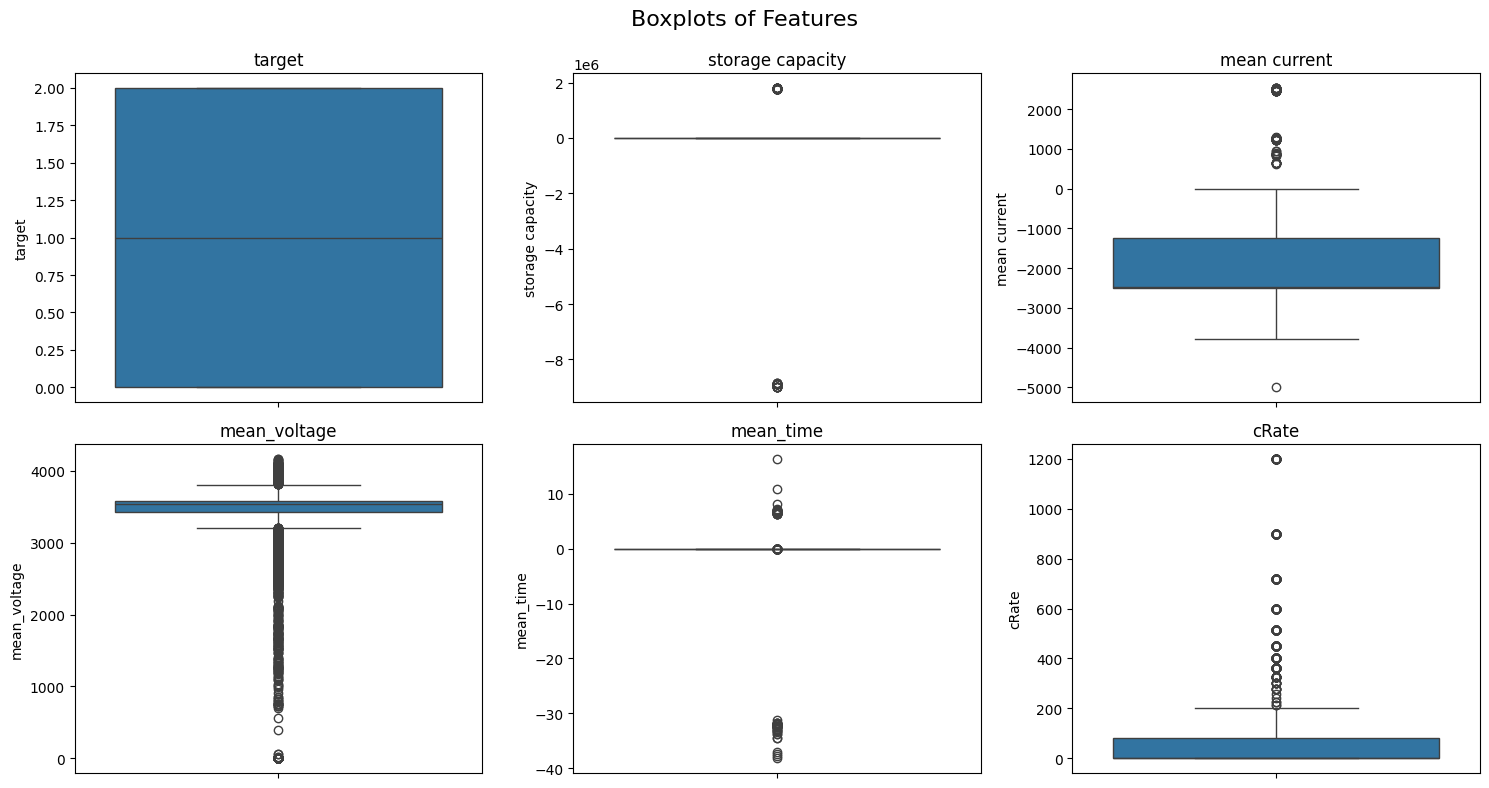

In [ ]:
# Set up subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.suptitle("Boxplots of Features", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create boxplots for each feature
for i, column in enumerate(new_data.columns):
    sns.boxplot(y=new_data[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

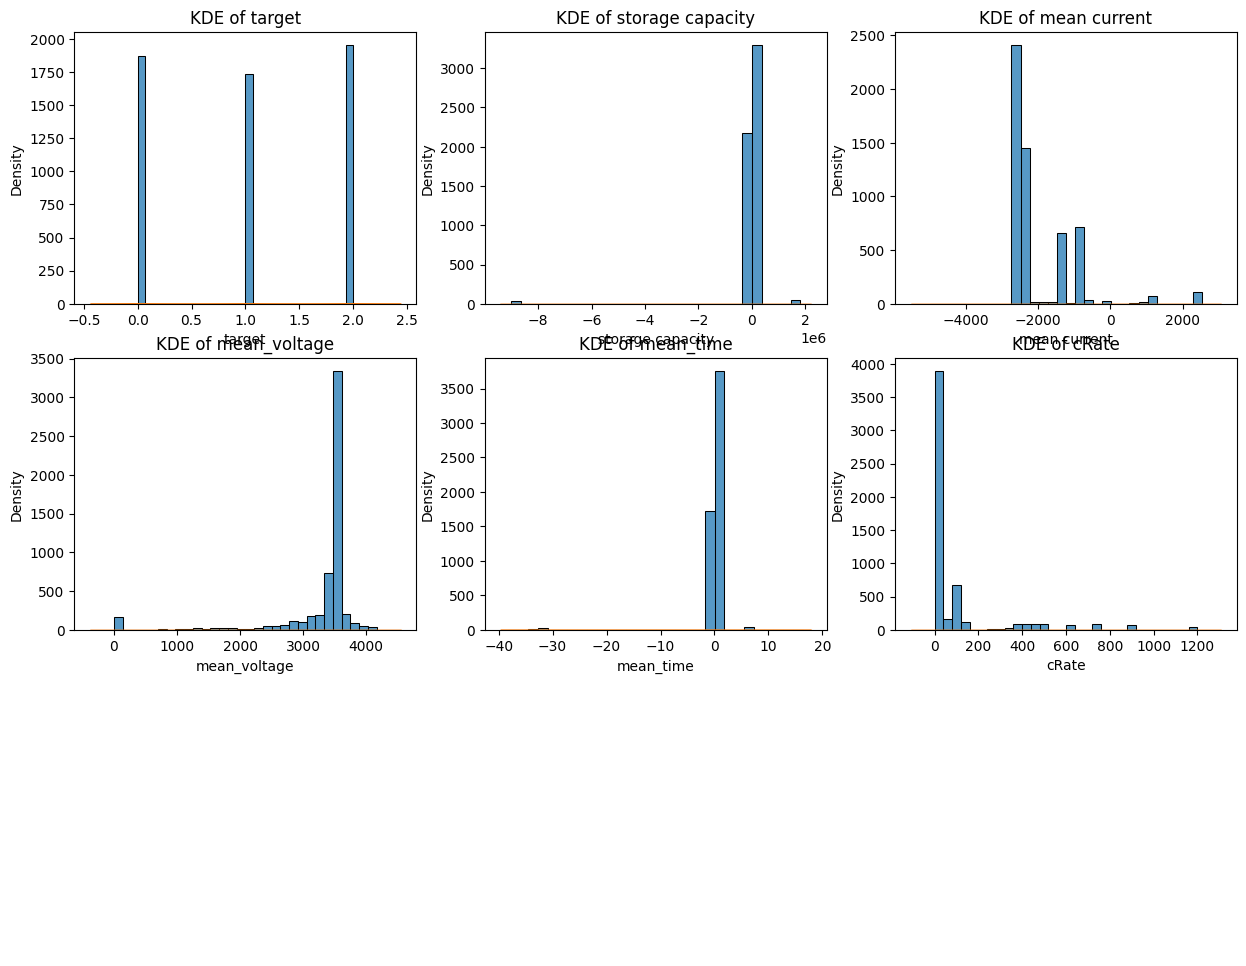

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Number of rows and columns for the subplots (based on the number of numerical features)
num_cols = 3  # Adjust this to control the number of columns in your subplot grid
num_rows = (len(new_data.select_dtypes(include=["float64", "int64"]).columns) // num_cols) + 1

# Set up the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot histograms & KDE for each numerical feature in subplots
for i, col in enumerate(new_data.select_dtypes(include=["float64", "int64"]).columns):
    # Plot histogram
    sns.histplot(new_data[col], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

    # Plot KDE
    plt.figure(figsize=(6, 4))
    sns.kdeplot(new_data[col], ax=axes[i], shade=True)
    axes[i].set_title(f"KDE of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

# Hide unused subplots
for i in range(len(new_data.select_dtypes(include=["float64", "int64"]).columns), len(axes)):
    axes[i].axis("off")

# Show the plot
plt.tight_layout()
plt.show()


Applying transformations


In [ ]:

# Assuming new_data is a DataFrame and 'storage capacity' is a feature/column
new_data['log_storage_capacity'] = np.log1p(new_data['storage capacity'])  # log1p handles zero values

# If you want to handle negative values, ensure that the values are non-negative before applying log
new_data['log_storage_capacity'] = np.log(new_data['storage capacity'] + 1)  # You can adjust this if needed

# Check the transformation
# print(new_data[['storage capacity', 'log_storage_capacity']].head())

new_data.head()

,target,storage capacity,mean current,mean_voltage,mean_time,cRate,log_storage_capacity
0,0,4453.468889,-2460.734513,3575.300885,0.016161,0.552543,8.401663
1,0,4551.944444,-2502.973451,3557.353982,0.016238,0.549869,8.423529
2,0,4146.091806,-2460.467290,3577.906542,0.015899,0.593443,8.330163
3,0,4775.188333,-2502.606838,3597.700855,0.016449,0.524085,8.471398
4,0,2.083333,-1250.000000,0.000000,0.001667,600.000000,1.126011


In [ ]:
from scipy import stats

# Shift values to be positive if necessary
shift_value = abs(new_data['mean current'].min()) + 1
new_data['mean_current_shifted'] = new_data['mean current'] + shift_value

# Apply Box-Cox transformation (Box-Cox only works with positive values)
new_data['boxcox_mean_current'], fitted_lambda = stats.boxcox(new_data['mean_current_shifted'])

# Check the transformation
print(new_data[['mean current', 'boxcox_mean_current']].head())


   mean current  boxcox_mean_current
0  -2460.734513            13.125970
1  -2502.973451            13.082431
2  -2460.467290            13.126244
3  -2502.606838            13.082812
4  -1250.000000            14.163487


In [ ]:
import numpy as np

# Shift the 'mean_voltage' values to ensure all are positive
shift_value = abs(new_data['mean_voltage'].min()) + 1
new_data['mean_voltage_shifted'] = new_data['mean_voltage'] + shift_value

# Apply the log transformation
new_data['log_mean_voltage'] = np.log(new_data['mean_voltage_shifted'])

# Check the transformation
print(new_data[['mean_voltage', 'log_mean_voltage']].head())


   mean_voltage  log_mean_voltage
0   3575.300885          8.182084
1   3557.353982          8.177053
2   3577.906542          8.182813
3   3597.700855          8.188328
4      0.000000          0.000000


In [ ]:
from scipy import stats

# Ensure the data is positive by shifting (if necessary)
shift_value = abs(new_data['mean_time'].min()) + 1
new_data['mean_time_shifted'] = new_data['mean_time'] + shift_value

# Apply Box-Cox transformation
new_data['boxcox_mean_time'], fitted_lambda = stats.boxcox(new_data['mean_time_shifted'])

# Check the transformation
print(new_data[['mean_time', 'boxcox_mean_time']].head())


   mean_time  boxcox_mean_time
0   0.016161      2.234418e+06
1   0.016238      2.234437e+06
2   0.015899      2.234353e+06
3   0.016449      2.234490e+06
4   0.001667      2.230794e+06


In [ ]:
import numpy as np

# Shift the 'CRate' values to ensure all are positive (adding 1 to handle zeros)
shift_value = abs(new_data['cRate'].min()) + 1
new_data['cRate_shifted'] = new_data['cRate'] + shift_value

# Apply the square root transformation
new_data['sqrt_cRate'] = np.sqrt(new_data['cRate_shifted'])

# Check the transformation
print(new_data[['cRate', 'sqrt_cRate']].head())

        cRate  sqrt_cRate
0    0.552543    1.246124
1    0.549869    1.245051
2    0.593443    1.262428
3    0.524085    1.234653
4  600.000000   24.515307


In [ ]:
new_data.drop(columns = ['storage capacity','mean current','mean_voltage','mean_time','cRate'],axis = 1,inplace = True)

In [ ]:
new_data.drop(columns = ['mean_current_shifted','mean_voltage_shifted','mean_time_shifted','cRate_shifted'],axis = 1,inplace = True)

In [ ]:
new_data.head()

,target,log_storage_capacity,boxcox_mean_current,log_mean_voltage,boxcox_mean_time,sqrt_cRate
0,0,8.401663,13.125970,8.182084,2.234418e+06,1.246124
1,0,8.423529,13.082431,8.177053,2.234437e+06,1.245051
2,0,8.330163,13.126244,8.182813,2.234353e+06,1.262428
3,0,8.471398,13.082812,8.188328,2.234490e+06,1.234653
4,0,1.126011,14.163487,0.000000,2.230794e+06,24.515307


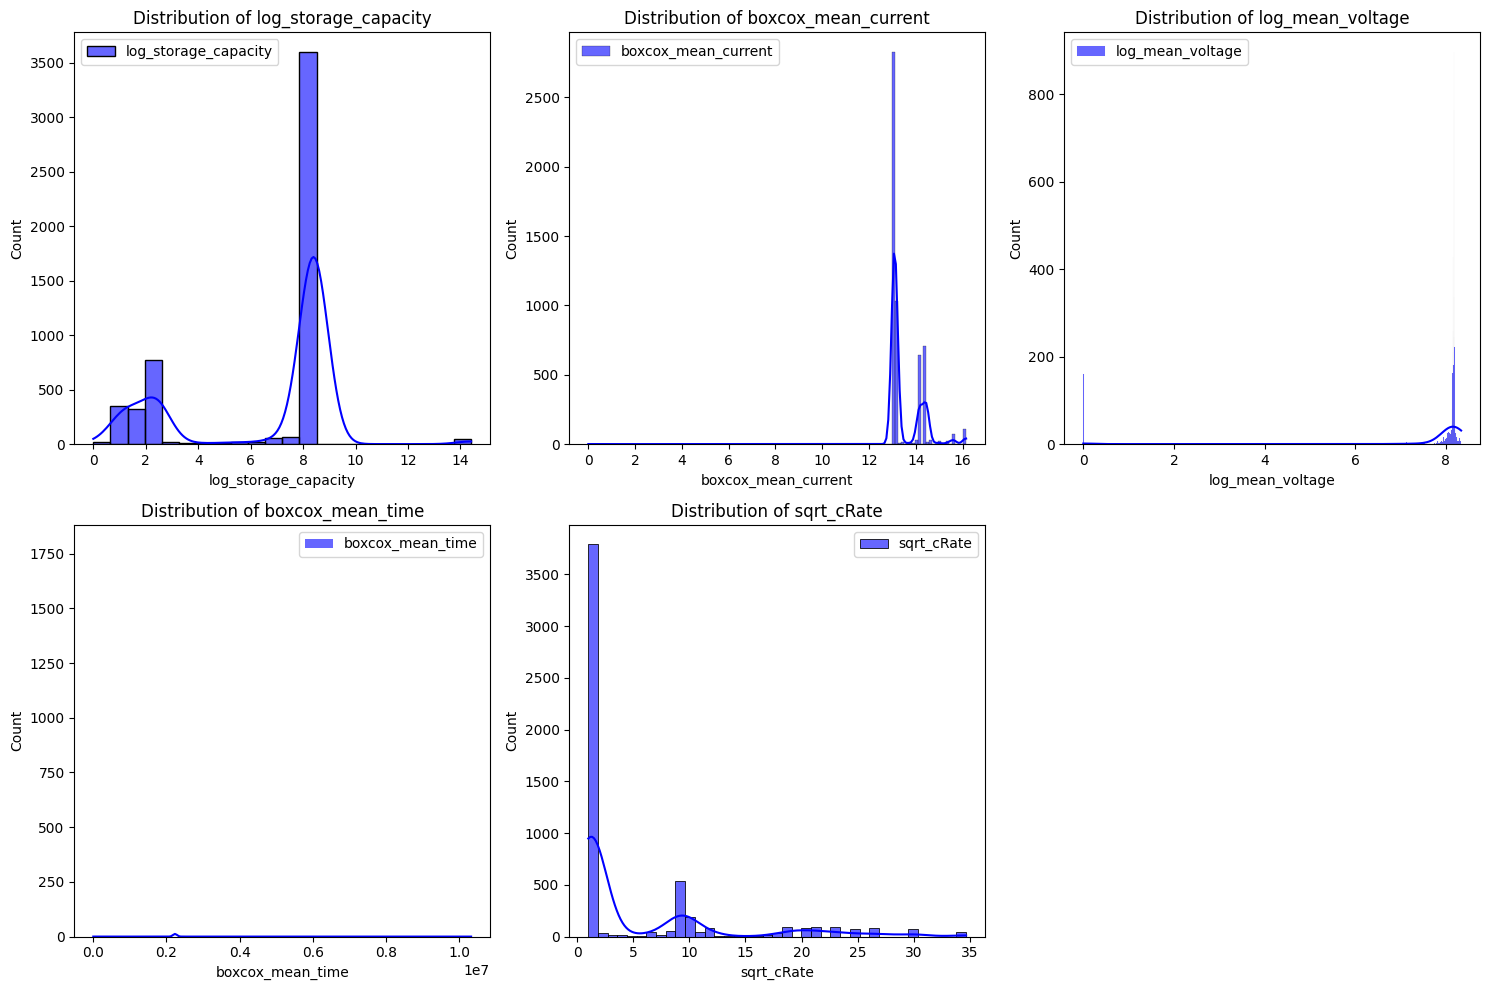

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of transformed features to plot
features = ['log_storage_capacity', 'boxcox_mean_current', 'log_mean_voltage', 'boxcox_mean_time', 'sqrt_cRate']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(new_data[feature], kde=True, color='blue', label=feature, alpha=0.6)
    plt.title(f'Distribution of {feature}')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import skew, kurtosis, shapiro

# Check skewness, kurtosis, and Shapiro-Wilk test
for feature in features:
    print(f"{feature} - Skewness: {skew(new_data[feature]):.2f}, Kurtosis: {kurtosis(new_data[feature]):.2f}")
    stat, p_value = shapiro(new_data[feature])
    print(f"Shapiro-Wilk test for {feature}: p-value = {p_value:.4f}\n")

log_storage_capacity - Skewness: nan, Kurtosis: nan
Shapiro-Wilk test for log_storage_capacity: p-value = nan

boxcox_mean_current - Skewness: 0.37, Kurtosis: 22.53
Shapiro-Wilk test for boxcox_mean_current: p-value = 0.0000

log_mean_voltage - Skewness: -5.44, Kurtosis: 28.08
Shapiro-Wilk test for log_mean_voltage: p-value = 0.0000

boxcox_mean_time - Skewness: 4.46, Kurtosis: 138.10
Shapiro-Wilk test for boxcox_mean_time: p-value = 0.0000

sqrt_cRate - Skewness: nan, Kurtosis: nan
Shapiro-Wilk test for sqrt_cRate: p-value = nan



<Axes: >

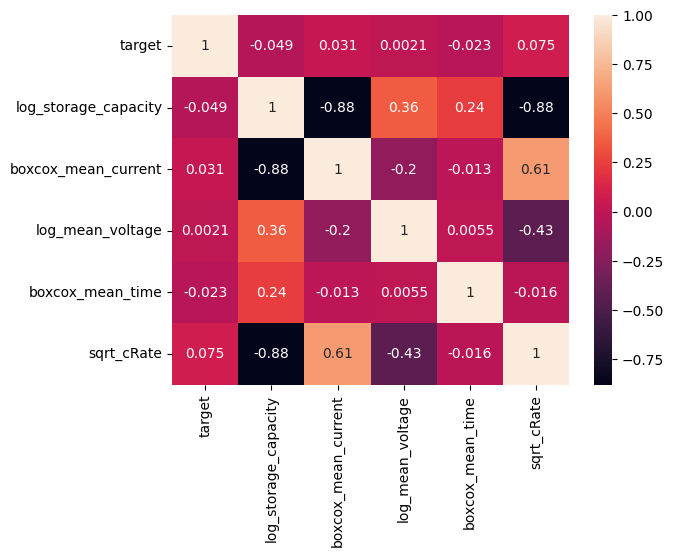

In [ ]:
sns.heatmap(new_data.corr(), annot = True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data.drop('target', axis=1), new_data['target'], test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Model Training
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create a Random Forest Classifier model
model = RandomForestClassifier()

# Train the model using the training data
model.fit(X_train, y_train)

# Predict on the test data (assuming you have X_test and y_test)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.6915467625899281

Confusion Matrix:
[[257  58  66]
 [ 54 238  48]
 [ 61  56 274]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       381
           1       0.68      0.70      0.69       340
           2       0.71      0.70      0.70       391

    accuracy                           0.69      1112
   macro avg       0.69      0.69      0.69      1112
weighted avg       0.69      0.69      0.69      1112



<Axes: >

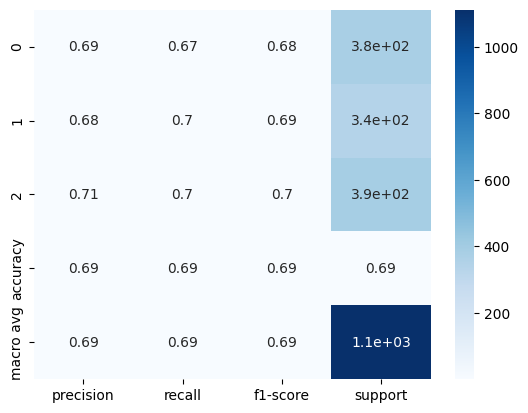

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming you already have the classification report stored in class_report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report dictionary to a DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

sns.heatmap(class_report_df.iloc[:-1, :].astype(float), annot=True, cmap='Blues')


In [ ]:
# Model Training with GridSearchCV and Pre-Pruning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Define a Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [1,2,3,4,5,6],  # Maximum depth of the trees
    'min_samples_split': [1,2,3],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False]  # Whether to use bootstrap samples
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print("\nBest Hyperparameters from GridSearchCV:", best_params)

# Train the model with the best parameters found
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best Hyperparameters from GridSearchCV: {'bootstrap': False, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Accuracy: 0.6834532374100719

Confusion Matrix:
[[230  68  83]
 [ 41 241  58]
 [ 52  50 289]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       381
           1       0.67      0.71      0.69       340
           2       0.67      0.74      0.70       391

    accuracy                           0.68      1112
   macro avg       0.69      0.68      0.68      1112
weighted avg       0.69      0.68      0.68      1112



In [ ]:
import numpy as np

# Replace NaN values with 0 (or any other value you prefer)
X = np.nan_to_num(X, nan=0)

<Axes: >

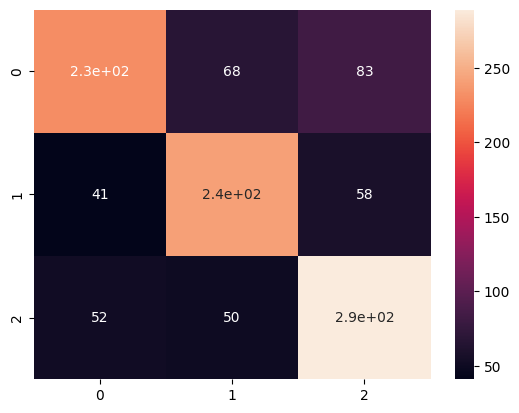

In [ ]:
sns.heatmap(conf_matrix, annot = True)